# Systèmes d’auto-apprentissage des risques par IA 

Sabri LAGHA


 ## Sujet: Algorithmes de mesure de risque financiers sur les données de ventes immobilières de Lyon (2018 à 2021)
  
  Ce risque peut être aggravé si les informations financières fausses sont utilisées pour prendre des décisions d'investissement ou pour évaluer la performance de l'entreprise.




# Création de la base de données initiale

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
url_dict = {
    '2021':'D:\\valeursfoncieres-2021.txt',
    '2020':'D:\\valeursfoncieres-2020.txt',
    '2019':'D:\\valeursfoncieres-2019.txt',
    '2018':'D:\\valeursfoncieres-2018.txt',
}
def collect():
  lyon_AY=[]
  for year,url in tqdm(url_dict.items()):
    print(f'----------STARTING YEAR {year}----------')
    data_ = pd.read_csv(url, sep="|")
    exclu=['COGNAT-LYONNE','LYONS LA FORET', 'BEAUFICEL-EN-LYONS','CHAZELLES SUR LYON','SAINTE FOY LES LYON', 'BEAUVOIR-EN-LYONS']
    data_2=data_[data_['Commune'].str.contains('LYON')]
    data_2 = data_2.drop(['Identifiant de document','Reference document','1 Articles CGI','2 Articles CGI',
                                      '3 Articles CGI','4 Articles CGI','5 Articles CGI','Identifiant local','No Volume','B/T/Q',
                                      'Surface Carrez du 1er lot','2eme lot','Surface Carrez du 2eme lot','3eme lot',
                                      'Surface Carrez du 3eme lot','4eme lot','Surface Carrez du 4eme lot','5eme lot',
                                      'Surface Carrez du 5eme lot','Nature culture','Nature culture speciale','Surface terrain',
                                      'Prefixe de section','Type de voie','Nombre de lots','1er lot','Code commune','Section','No plan','Code voie',
                                      'Code type local'], axis=1)
    data_2=data_2[np.logical_not(data_2.isin(exclu))]
    data_2=data_2[data_2['Commune'].notnull()]
    data_2['year']=year
    lyon_AY.append(data_2)
    del data_2
  df=pd.concat(lyon_AY)
  return df

df=collect()

In [141]:
import pandas as pd
df=pd.read_csv('D:\\data_lyon_AR.csv')

Traitement de base des données


In [142]:
df['Date mutation'] = pd.to_datetime(df['Date mutation'], format='%d/%m/%Y')
df = df.drop_duplicates()
df = df[df['Type local'].isin(['Maison','Appartement'])]
df['Valeur fonciere'] = df['Valeur fonciere'].astype(str)
df['Valeur fonciere'] = df['Valeur fonciere'].str.replace(',','.')
df['Valeur fonciere'] = df['Valeur fonciere'].astype(float)
df['Valeur fonciere'] = df['Valeur fonciere'].round(0)
df = df[df['Valeur fonciere'] < 1000000]
df=df[df['Nature mutation'].isin(['Vente',"Vente en l'état futur d'achèvement"])]
df['Code postal'] = df['Code postal'].astype(int)
df['Valeur fonciere'] = df['Valeur fonciere'].astype(int)
df=df.drop(columns=['Code departement','No disposition','No voie','Voie','Code postal'],axis=1)
df = df.rename(columns={'Unnamed: 0': 'Numero transaction'})

In [143]:
df.head()

,Numero transaction,Date mutation,Nature mutation,Valeur fonciere,Commune,Type local,Surface reelle bati,Nombre pieces principales,year
0,3126323,2021-01-05,Vente,375000,LYON 5EME,Appartement,108.0,5.0,2021
1,3126327,2021-01-04,Vente,203050,LYON 5EME,Appartement,83.0,5.0,2021
2,3126330,2021-01-04,Vente,140000,LYON 9EME,Appartement,73.0,3.0,2021
3,3126331,2021-01-04,Vente,174100,LYON 9EME,Appartement,69.0,3.0,2021
4,3126333,2021-01-05,Vente,432200,LYON 4EME,Appartement,29.0,1.0,2021


In [146]:
len(df)

37592

In [144]:
import plotly.express as px
df['Prix au mcarré']= df['Valeur fonciere']/(df['Surface reelle bati'])
df_bp = df[df['Prix au mcarré'] < 20000]
fig = px.box(df_bp, x="year", y="Prix au mcarré", hover_data=['Valeur fonciere','Surface reelle bati'],title='BP du prix au m² par année')
fig.show()

<Axes: xlabel='Date mutation', ylabel='Prix au mcarré'>

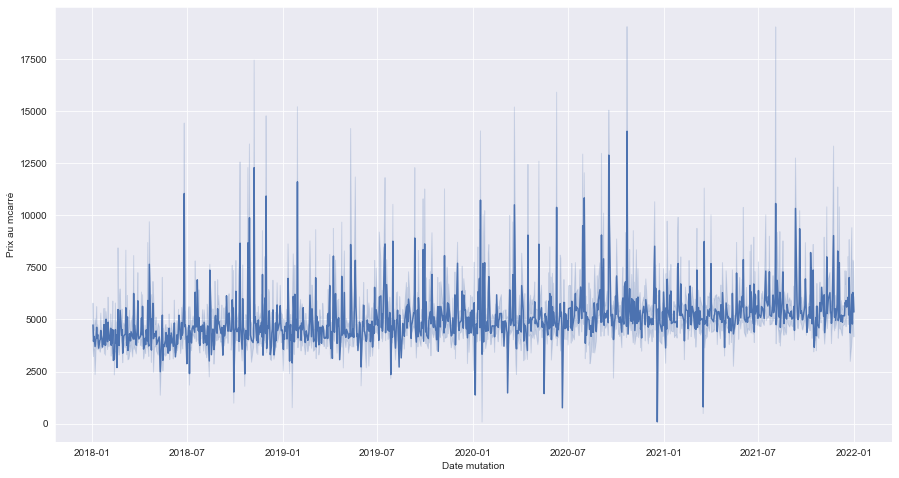

In [145]:
import seaborn as sns
df_bp = df[df['Prix au mcarré'] < 20000]
sns.set({'figure.figsize':(15,8)})
sns.lineplot(x="Date mutation", y="Prix au mcarré",data=df.sort_values('Date mutation'))

Indicateurs et label pour conditionner les etiquettes

In [147]:

#définir notre indicateur 
df['Prix au mcarré']= df['Valeur fonciere']/(df['Surface reelle bati'])
#définir nos conditions de label pour la nouvelle étiquette
df['Vrai prix']='oui'
df.loc[(df['Prix au mcarré'] > 8000) & (df['year'] == 2018), 'Vrai prix'] = 'non'
df.loc[(df['Prix au mcarré'] > 8500) & (df['year'] == 2019), 'Vrai prix'] = 'non'
df.loc[(df['Prix au mcarré'] > 9000) & (df['year'] == 2020), 'Vrai prix'] = 'non'
df.loc[(df['Prix au mcarré'] > 9500) & (df['year'] == 2021), 'Vrai prix'] = 'non'
df.loc[(df['Prix au mcarré'] < 1800) & (df['year'] == 2018), 'Vrai prix'] = 'non'
df.loc[(df['Prix au mcarré'] < 2200) & (df['year'] == 2019), 'Vrai prix'] = 'non'
df.loc[(df['Prix au mcarré'] < 2400) & (df['year'] == 2020), 'Vrai prix'] = 'non'
df.loc[(df['Prix au mcarré'] < 2600) & (df['year'] == 2021), 'Vrai prix'] = 'non'
df.loc[(df['Nombre pieces principales'] > 13) & (df['Surface reelle bati'] < 20), 'Vrai prix'] = 'non'
df.loc[df['Prix au mcarré'] < 2950, 'Vrai prix'] = 'non'
df.loc[df['Surface reelle bati'] <= 10, 'Vrai prix'] = 'non'

In [148]:
df.head()

,Numero transaction,Date mutation,Nature mutation,Valeur fonciere,Commune,Type local,Surface reelle bati,Nombre pieces principales,year,Prix au mcarré,Vrai prix
0,3126323,2021-01-05,Vente,375000,LYON 5EME,Appartement,108.0,5.0,2021,3472.222222,oui
1,3126327,2021-01-04,Vente,203050,LYON 5EME,Appartement,83.0,5.0,2021,2446.385542,non
2,3126330,2021-01-04,Vente,140000,LYON 9EME,Appartement,73.0,3.0,2021,1917.808219,non
3,3126331,2021-01-04,Vente,174100,LYON 9EME,Appartement,69.0,3.0,2021,2523.188406,non
4,3126333,2021-01-05,Vente,432200,LYON 4EME,Appartement,29.0,1.0,2021,14903.448276,non


C:\Users\33648\AppData\Local\Temp\ipykernel_13616\1085838433.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



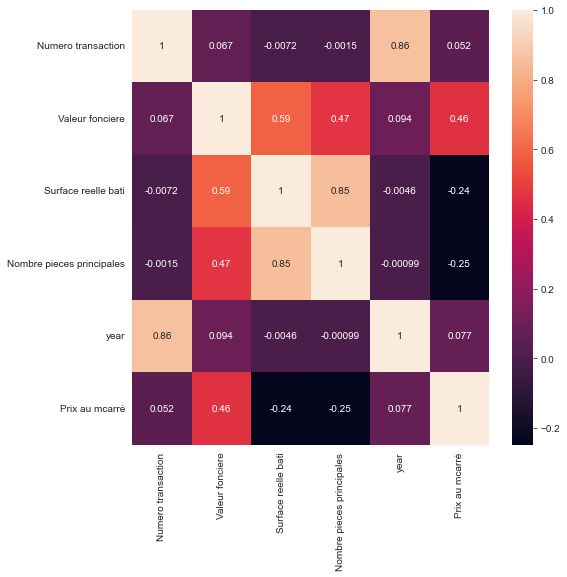

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_df =df.corr(method='pearson')
plt.figure(figsize=(8, 8))
#plt.matshow(corr_df)
sns.heatmap(corr_df, annot=True)
plt.show()

Modèle de prédiction pour estimer la valeur de risque (Arbre de décision)

### Random Forest Classifer

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


df.dropna(inplace=True)
X = df[['Surface reelle bati', 'Nombre pieces principales', 'Prix au mcarré','year','Type local','Valeur fonciere']]
y = df['Vrai prix']
#convertir en booléen la valeur Appartement ou Maison
X['Type local'] = (X['Type local'] == 'Appartement').astype(int)
# Séparer les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dt = RandomForestClassifier(n_estimators=100, random_state=42)
dt.fit(X_train, y_train)
# Prédire les résultats sur l'ensemble de test
y_pred = dt.predict(X_test)

# Évaluer la performance du modèle
print("Accuracy score: ", round(accuracy_score(y_test, y_pred),2)*100,'%')
print("Classification report: ", classification_report(y_test, y_pred))
#Le modèle présente une accuracy parfaite car il a détécté toutes nos conditions d'attribution automatisée d'étiquette

C:\Users\33648\AppData\Local\Temp\ipykernel_13616\3456660959.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Accuracy score:  100.0 %
Classification report:                precision    recall  f1-score   support

         non       1.00      1.00      1.00      1477
         oui       1.00      1.00      1.00      6041

    accuracy                           1.00      7518
   macro avg       1.00      1.00      1.00      7518
weighted avg       1.00      1.00      1.00      7518



### Decision Tree Classifier

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


df.dropna(inplace=True)
X = df[['Surface reelle bati', 'Nombre pieces principales', 'Prix au mcarré','year','Type local','Valeur fonciere']]
y = df['Vrai prix']
#convertir en booléen la valeur Appartement ou Maison
X['Type local'] = (X['Type local'] == 'Appartement').astype(int)
# Séparer les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
# Prédire les résultats sur l'ensemble de test
y_pred = dt.predict(X_test)

# Évaluer la performance du modèle
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
#Le modèle présente une accuracy parfaite car il a détécté toutes nos conditions d'attribution automatisée d'étiquette






C:\Users\33648\AppData\Local\Temp\ipykernel_13616\1806853089.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Accuracy score:  1.0
Classification report:                precision    recall  f1-score   support

         non       1.00      1.00      1.00      1477
         oui       1.00      1.00      1.00      6041

    accuracy                           1.00      7518
   macro avg       1.00      1.00      1.00      7518
weighted avg       1.00      1.00      1.00      7518



Générer un mail d'alerte

In [50]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Adresse e-mail et mot de passe pour se connecter à votre compte Gmail
gmail_address = "sabri.lagha97@gmail.com"
gmail_password = "rwkcqwsuvkuxpxlh"

# Adresse e-mail du destinataire
to_address = "sabri.lagha97@gmail.com"

# Objet et contenu de l'e-mail
subject = "Mise à jour du modèle de prédiction "
body = "Le nouveau modèle est plus efficace que l'ancien suite à la modification des données d'entrée"

# Créer le message
msg = MIMEMultipart()
msg["From"] = gmail_address
msg["To"] = to_address
msg["Subject"] = subject
msg.attach(MIMEText(body, "plain"))

# Envoyer le message
with smtplib.SMTP("smtp.gmail.com", 587) as server:
    server.starttls()
    server.login(gmail_address, gmail_password)
    server.sendmail(gmail_address, to_address, msg.as_string())

Système de comparaison de l'ancien et du nouveau modèle + Générer mail lorsque des modif ont été détéctés

In [150]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier


def retrain_model(X_train, y_train, X_test, y_test):
    # Entraîner un nouveau modèle
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)

    # Faire des prédictions avec le nouveau modèle
    y_pred = model.predict(X_test)

    # Calculer la précision du nouveau modèle
    accuracy = accuracy_score(y_test, y_pred)

    # Si le modèle précédent existe et si la précision du nouveau modèle est supérieure à celle du modèle précédent
    if accuracy_score(y_test, y_pred) is not None and accuracy == accuracy_score(y_test, y_pred):
        print("Le nouveau modèle est meilleur que l'ancien modèle.")
        print("nouveau modèle :" ,model, "accuracy: ", round(accuracy,2)*100,'%')
        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login(gmail_address, gmail_password)
            server.sendmail(gmail_address, to_address, msg.as_string())
    else:
        print("Le nouveau modèle n'est pas meilleur que l'ancien modèle.")
        print("ancien modèle:" ,dt, "accuracy: ",round(accuracy_score(y_test, y_pred),2)*100,'%')
        return {'ancien modèle': dt, 'accuracy':accuracy_score(y_test, y_pred)}
    
test=retrain_model(X_train, y_train, X_test, y_test)

Le nouveau modèle est meilleur que l'ancien modèle.
nouveau modèle : AdaBoostClassifier() accuracy:  100.0 %
